## First We Prepare An Artificial Dataset

In [1]:
import random
import csv

# Define the center coordinate
center_latitude = 20.3555
center_longitude = 85.8161

# Define the maximum distance from the center coordinate
max_distance = 0.01

# Define the number of data instances to generate
num_data_instances = 1500

# Create a list to store the data instances
data_instances = []

# Generate random locations within the specified distance from the center coordinate
for i in range(num_data_instances):
    # Generate a random latitude and longitude within the specified distance
    latitude = random.uniform(center_latitude - max_distance, center_latitude + max_distance)
    longitude = random.uniform(center_longitude - max_distance, center_longitude + max_distance)

    # Create a data instance
    data_instance = {}
    data_instance['Location'] = f'{latitude:.6f} N, {longitude:.6f} E'

    # Generate a random time
    hour = random.randint(0, 23)
    minute = random.randint(0, 59)
    second = random.randint(0, 59)

    # Create a time string
    time = f'{hour}:{minute}:{second}'

    # Add the time to the data instance
    data_instance['Time'] = time

    # Add the data instance to the list
    data_instances.append(data_instance)

# Write the data instances to a CSV file
with open('database.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Location', 'Time'])
    for data_instance in data_instances:
        writer.writerow([data_instance['Location'], data_instance['Time']])


# Now we access the Dataset In Form On Database and Prepare it

In [2]:
#Accessing the dataset
import pandas as pd
crime_data=pd.read_csv("database.csv")
crime_data.head()

,Location,Time
0,"20.350773 N, 85.821616 E",0:54:10
1,"20.351011 N, 85.812916 E",9:46:6
2,"20.348301 N, 85.810293 E",4:24:27
3,"20.357082 N, 85.813052 E",22:20:32
4,"20.359461 N, 85.823226 E",3:10:44


In [3]:
#Here we are accessing the time column of the dataframe and giving it the specific date time format so that we can use it 
#later for filtration
crime_data['Time'] = pd.to_datetime(crime_data['Time'], format='%H:%M:%S').dt.time

In [4]:
#Now we are accessing the current time of the system. So that relevant map can be generated
import datetime

# Get the current date and time
current_datetime = datetime.datetime.now()

# Extract the current time
current_time = current_datetime.time()

print("Current time:", current_time)


Current time: 20:42:37.171169


In [5]:
#Here we are accessing the hour part of the current time to filter the data.
import datetime

# Get the current date and time
current_datetime = datetime.datetime.now()

# Access the hour component
current_hour = current_datetime.hour

print("Current hour:", current_hour)


Current hour: 20


In [6]:
#Now we filter the data on the basis of current time
start_time = pd.to_datetime("{}:00:00".format(current_hour), format='%H:%M:%S').time()
if(current_hour+1==24):
    end_time = pd.to_datetime("00:00:00", format='%H:%M:%S').time()
else:
    end_time = pd.to_datetime("{}:00:00".format(current_hour+1), format='%H:%M:%S').time()

filtered_data = crime_data[(crime_data['Time'] >= start_time) & (crime_data['Time'] <= end_time)]
filtered_data

,Location,Time
11,"20.360881 N, 85.808225 E",20:37:09
13,"20.347931 N, 85.822247 E",20:38:28
17,"20.361400 N, 85.819332 E",20:01:26
47,"20.362548 N, 85.817414 E",20:48:20
49,"20.349891 N, 85.812691 E",20:10:56
...,...,...
1382,"20.350686 N, 85.806974 E",20:46:00
1383,"20.357323 N, 85.816660 E",20:59:54
1463,"20.356482 N, 85.806520 E",20:01:40
1476,"20.358909 N, 85.819910 E",20:07:57


In [7]:
latitude_array=[]
longitude_array=[]
for location in filtered_data["Location"]:
    parts=location.split(', ')
    parts_further_lat=parts[0].split(' ')
    parts_further_long=parts[1].split(' ')
    latitude=float(parts_further_lat[0])
    longitude =float(parts_further_long[0])
    latitude_array.append(latitude)
    longitude_array.append(longitude)
filtered_data["Latitude"]=latitude_array
filtered_data["Longitude"]=longitude_array
filtered_data.head();

C:\Users\ashut\AppData\Local\Temp\ipykernel_15332\3624560615.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["Latitude"]=latitude_array
C:\Users\ashut\AppData\Local\Temp\ipykernel_15332\3624560615.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["Longitude"]=longitude_array


In [16]:
import folium

# Central coordinates
central_location = (20.3555, 85.8161)

# Create a Folium map centered around the central location
southwest_bound = (20.3455, 85.8061)
northeast_bound = (20.3654, 85.8260)
m = folium.Map(location=central_location, zoom_start=1000,bounds=[southwest_bound, northeast_bound])

# Add markers for each location
for location in filtered_data["Location"]:
    parts=location.split(', ')
    parts_further_lat=parts[0].split(' ')
    parts_further_long=parts[1].split(' ')
    latitude=float(parts_further_lat[0])
    longitude =float(parts_further_long[0])
    location=(latitude,longitude)
    folium.Marker(location=location).add_to(m)


# Save or display the map
m.save('map_with_overlay.html')

from IPython.display import display
display(m)  # Display the map in Jupyter Notebook



In [9]:
from sklearn.neighbors import KernelDensity
import numpy as np

location_storage=[]
# Sample spatial data (latitude and longitude)
for i in range(len(filtered_data)):
    lat=latitude_array[i]
    long=longitude_array[i]
    loc_datapoint=[lat,long]
    location_storage.append(loc_datapoint)
data=np.array(location_storage)
len(data)

65

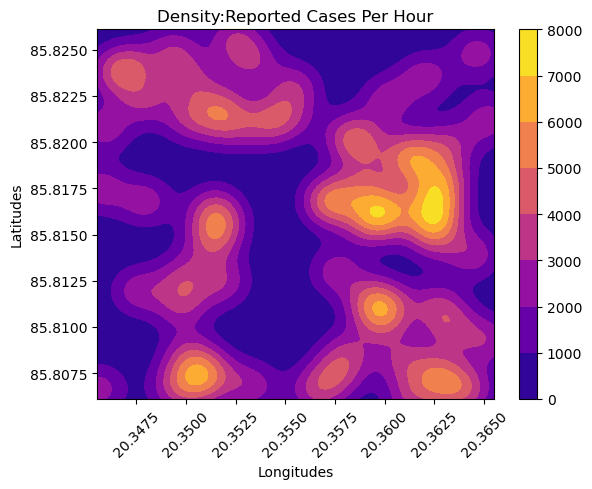

In [17]:
# Create a Kernel Density Estimation model
kde = KernelDensity(bandwidth=0.001)  # You can adjust the bandwidth

# Fit the model to your data
kde.fit(data)

# Generate a grid of points for density estimation
x, y = np.meshgrid(np.linspace(20.345526, 20.365477, 100), np.linspace(85.8061, 85.826098, 100))
grid_points = np.vstack([x.ravel(), y.ravel()]).T

# Estimate the density at each grid point
density_values = np.exp(kde.score_samples(grid_points))

# You can use 'density_values' to color the map or create contour plots

# Optional: Display the density values or create visualizations
import matplotlib.pyplot as plt
plt.contourf(x, y, density_values.reshape(x.shape),cmap='plasma')
plt.colorbar()
ax=plt.gca().xaxis
#The code above creates an access to artists of x axis.
for i in ax.get_ticklabels():
    i.set_rotation(45)
plt.xlabel("Longitudes")
plt.ylabel("Latitudes")
plt.title("Density:Reported Cases Per Hour")
plt.show()

# Display the map
m.save('heatmap_map.html')

In [11]:
len(density_values)

10000

AttributeError: 'QuadContourSet' object has no attribute 'figure'

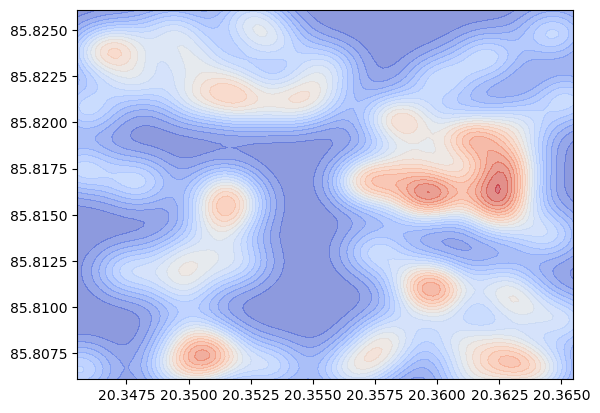

In [12]:
import folium

import numpy as np
import matplotlib.pyplot as plt

# Create a Folium map
m = folium.Map(location=central_location, zoom_start=12)

# Create a contour plot of the KDE density values
x, y = np.meshgrid(np.linspace(20.345526, 20.365477, 100), np.linspace(85.8061, 85.826098, 100))
density_values = density_values.reshape(x.shape)
contour_plot = plt.contourf(x, y, density_values, levels=20, cmap='coolwarm', alpha=0.6)

# Convert the contour plot to an image
fig = contour_plot.figure
fig.canvas.draw()
image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

# Define the bounds for the image overlay
overlay_bounds = [(x.min(), y.min()), (x.max(), y.max())]

# Add the image overlay to the Folium map with lower opacity
layer=folium.raster_layers.ImageOverlay(image=image, bounds=overlay_bounds, opacity=0.6).add_to(m)

# Save or display the map
m.save('heatmap_map_with_overlay.html')


In [ ]:
import folium
import geojson

# Load the heatmap data
with open("heatmap_map.html", "r", encoding="utf-8") as file:
    html_content = file.read()

# Now 'html_content' contains the content of the HTML file


# Convert the heatmap data to a GeoJSON object
geojson_object = geojson.FeatureCollection(
    features=[
        geojson.Feature(
            geometry=geojson.Point([20.3555, 85.8161]),
            properties={"density": html_content}),
    ]
)

# Create a folium map
m = folium.Map(location=[20.3555, 85.8161], zoom_start=15)

# Create a Layer object and pass in the GeoJSON object
layer = folium.map.Layer(geojson_object)

m.add_child(layer)
from IPython.display import display
display(m)  # Display the map in Jupyter Notebook

